## Assignment A3b: Filtering

### David Courtney 3643806

In [1]:
using DSP, HDF5, LinearAlgebra, Plots, Plots.PlotMeasures, Random, Statistics, WAV

# Professor Lewicki's version of gabor
function gabor(x; f=1, sigma=1/f, phi=0, a=1)
    return a*exp(-x^2/(2sigma^2)) * cos(2pi*f*x + phi)
end

# My gabor code from A1b
#function gabor(t, f, sigma, phi, a)
#    return a .* exp.(- (t.^2) ./ (2 * sigma^2)) .* cos.(2pi * f .* t .+ phi)
#end

# Code from A1b
function gaboro(t; f, sigma, a=1)
    return gabor(t, f, sigma, (pi/2), a)
end

# Professor Lewicki's version of gabore
function gabore(x::AbstractArray; args...)
    g = gabor.(x; args...)
    return g ./ norm(g)
end

# My gabore code from A1b
#function gabore(t; f, sigma, a=1)
#    return gabor(t, f, sigma, 0, a)
#end

# Code from A1b
function gabor_norm(f, sigma, phi, fs)
    t_range_start = -4 * sigma
    t_range_stop = 4 * sigma
    num_samples = Int(round((8 + sigma) * sigma * fs))
    t_samples = range(t_range_start, stop=t_range_stop, length=num_samples)
    gabor_values_squared = [gabor(t, f, sigma, phi, 1)^2 for t in t_samples]
    sum_of_squares = sum(gabor_values_squared)
    return sqrt(sum_of_squares)
end

# Code from A1b
function gabore_norm(; f, sigma, fs)
    return gabor_norm(f, sigma, 0, fs)
end

# Code from A1b
function gaboro_norm(f=f, sigma=sigma, fs=fs)
    return gabor_norm(f=f, sigma=sigma, phi=pi/2, fs=fs)
end

# Code from A1b/A3a
function sinewave(t; f=1.0, d=0.0)
    return sin.(2 * pi * f * (t .- d))
end

# Code from A1b/A3a
function ERB(f)
    return 24.7 * (4.37 * f / 1000 + 1)
end

# Professor Lewicki's version of gammatone
function gammatone(t; f=1, phi=0, n=4, a=1, fs=1)
    t <= 0.0 && return 0.0
    # normalize if samp freq is provided
    # and normalizing const is not (ie the default a==1)
    if fs != 1 && a == 1
        a = 1/gammatone_norm(; f, phi, n, fs)
    end
    b = 1.019 * ERB(f)
    return a*t^(n-1) * exp(-2 * pi * b * t) * cos(2 * pi * f *t + phi)
end

# Professor Lewicki's version of gammatone_norm
function gammatone_norm(; f=1, phi=0, n=4, fs=1)
    t = range(0, 20/f, step=1/fs) # non-zero range
    return norm(gammatone.(t; f, phi, n))
end

# Code from A3a (modified for A3b)
function noisysignal(t, g; tau=1.0, T, sigma)
    signal_value = g(t)
    signal       = ((tau <= t) && (t <= tau + T)) ? signal_value : 0.0
    noise        = sigma * randn()

    return signal + noise
end

# 1b
function movingavg(x; lambda=0.5)
    y = zeros(length(x))
    y[1] = x[1] * (1 - lambda)
    for n in 2:length(x)
        y[n] = lambda * y[n-1] + (1 - lambda) * x[n]
    end
    return y
end

# 1b
function randprocess(N; sigma=1)
    x = zeros(N)
    x[1] = randn() * sigma
    for i in 2:N
        x[i] = x[i-1] + randn() * sigma
    end
    return x
end

# 1b
function generate_noisy_sine_wave(N; f=1.0, fs=100, sigma=0.5)
    t = 0:1/fs:(N-1)/fs
    sine_wave = sinewave(t; f=f)
    noisy_sine = sine_wave .+ sigma * randn(length(t))
    return t, noisy_sine
end

# 2b
function filterIIR(x; a, b)
    N = length(x)
    y = zeros(N)

    M = length(b)
    L = length(a)

    for n = 1:N
        for k = 0:min(n-1, M-1)
            y[n] += b[k+1] * x[n-k]
        end

        for k = 1:min(n-1, L)
            y[n] -= a[k] * y[n-k]
        end
    end

    return y
end

# 2d
function noisefreqplot(; t, freqs, sigma_s, a, b)
    plotkw = (size=(600, 500), legend=false, 
        xticks=range(10^3*t[1], 10^3*t[end], length=3),
        xguidefontsize=9, yguidefontsize=9)

    subfigs = []
    ymax = ymin = 0.0
    for (i, sigma) in enumerate(sigma_s), (j, f) in enumerate(freqs)
        signal = sinewave(t; f)
        y = signal + randn(length(t)) * sigma
        ymax = max(ymax, maximum(y))
        ymin = min(ymin, minimum(y))
        xlabel = (i == length(freqs) ? "f=$f" : "")
        ylabel = (j == 1 ? "σ=$sigma" : "")
        push!(subfigs, plot(10^3*t, y; xlabel, ylabel, plotkw...))
    end

    ylim = (ymin, ymax)
    fig = plot(subfigs...; ylim, layout=grid(length(sigma_s), length(freqs)))
    return fig
end

# 2d
function power(x)
    return sum(abs.(x).^2) / length(x)
end

function plotFrequencyResponse(filterA, filterB)
    fs             = 2000
    times          = LinRange(0, 1, fs)
    frequencyArray = LinRange(0, fs/2, fs)
    powerArray     = zeros(length(frequencyArray))

    for i in 1:length(frequencyArray)
        sinWave         = sinewave(times, f=frequencyArray[i])
        sinWaveFiltered = filterIIR(sinWave, a=filterA, b=filterB)
        powerArray[i]   = power(sinWaveFiltered)
    end

    max_power_index = argmax(powerArray)
    peak_freq       = frequencyArray[max_power_index]
    peak_power      = powerArray[max_power_index]

    println("Peak frequency: ", peak_freq, " Hz with power ", peak_power)

    plot(frequencyArray, powerArray, title="", xlabel="input frequency (Hz)", ylabel="output power", legend=false)
end

# 4a
function convolve(x; h=[1], h0=1)
    N = length(x)
    M = length(h)
    y = zeros(Float64, N)  # Initialize the output vector with zeros

    #Convolve x with h
    for n in 1:N
        # Because Julia is 1-based, we adjust the indices accordingly
        for k in 1:M
            j = n - k + h0  # Convert the offset to an index, considering h0
            # Check bounds, because we can't use negative or out-of-bounds indices
            if j > 0 && j <= N
                y[n] += x[j] * h[k]
            end
        end
    end

    return y
end

# 4a
function generate_delayed_signal(t; g, tau, T, fs)
    delayed_signal = [((ti >= tau) && (ti <= tau + T)) ? g(ti - tau) : 0.0 for ti in t]
    return delayed_signal
end

function add_noise(signal, sigma)
    noise = randn(length(signal)) * sigma
    return signal + noise
end

# Matched filter function

function matched_filter(signal, template)
    full_conv_result = conv(signal, reverse(template))
    start_index      = div(length(template), 2) + 1
    end_index        = start_index + length(signal) - 1
    start_index      = max(start_index, 1)
    end_index        = min(end_index, length(full_conv_result))
    
    return full_conv_result[start_index:end_index]
end

function matched_filter_fig(; fs=2000, t=0:1/fs:0.100, f=250, sigma=0.1, tau=0.050)
    plotkw = (size=(500,400), legend=false, titlefontsize=11)
    g = t -> gammatone(t; f=f, fs=fs)

    signal = [gammatone(ti; f=f, fs=fs) for ti in t]
    noisysignal = add_noise(signal, sigma)

    delayed_signal          = generate_delayed_signal(t; g=g, tau=tau, T=0.100, fs=fs)
    delayed_noisy_signal    = add_noise(delayed_signal, sigma)
    template                = [gammatone(ti; f=f, fs=fs) for ti in t]
    filtered_signal         = matched_filter(noisysignal, template)

    p1 = plot(t .* 1000, delayed_signal; title="signal", plotkw...)
    p2 = plot(t .* 1000, delayed_noisy_signal; title="with noise σ=$sigma", plotkw...)
    p3 = plot(t .* 1000, filtered_signal; title="matched filter output", plotkw...)

    return plot(p1, p2, p3, layout=(3,1), xlabel="msecs", ylabel="")
end



matched_filter_fig (generic function with 1 method)

In [2]:
using Test

@testset "movingavg" begin
    x = [1, 1, 1, 1]
    @test movingavg(x; lambda=0.5) == [0.5, 0.75, 0.875, 0.9375]
end

@testset "filterIIR" begin
    # test first order
    x = [1, 1, 1]
    a1, b0, b1 = 1, 1, 1
    a = [a1]
    b = [b0, b1]
    y = filterIIR(x; a, b)
    @test y[1] == b0*x[1]
    @test y[2] == b0*x[2] + b1*x[1] - a1*y[1]
    @test y[3] == b0*x[3] + b1*x[2] - a1*y[2]

    # test second order
    x = [1, 1, 1, 1]
    a1, a2, b0, b1, b2 = 1, 1, 1, 1, 1
    a = [a1, a2]
    b = [b0, b1, b2]
    y = filterIIR(x; a, b)
    @test y[1] == b0*x[1]
    @test y[2] == b0*x[2] + b1*x[1] - a1*y[1]
    @test y[3] == b0*x[3] + b1*x[2] + b2*x[1] - (a1*y[2] + a2*y[1])
    @test y[4] == b0*x[4] + b1*x[3] + b2*x[2] - (a1*y[3] + a2*y[2])
end

@testset "convolve" begin
    @test convolve([1 2 3]; h=[1]) == [1.0, 2.0, 3.0] # impulse
    @test convolve([1 2 3]; h=[0 1]) == [0.0, 1.0, 2.0] # delay
    @test convolve([1 2 3]; h=[0 1 0], h0=2) == [1.0, 2.0, 3.0]

    x = [1 2 1 2 1 ]
    h = [0.5 1 0.5]
    @test convolve(x; h=h, h0=2) == [2.0, 3.0, 3.0, 3.0, 2.0]
end

Test Summary: | Pass  Total  Time
movingavg     |    1      1  0.4s
Test Summary: | Pass  Total  Time
filterIIR     |    7      7  0.1s
Test Summary: | Pass  Total  Time
convolve      |    4      4  0.1s


Test.DefaultTestSet("convolve", Any[], 4, false, false, true, 1.709779238666e9, 1.70977923879e9, false, "In[2]")

### 1. Filtering


### 1a. A moving average filter


#### Derving the equation
$
\begin{align}
y_M[n] &= \frac{1}{M} \sum_{k=0}^{M-1} x[n-k] \tag{1} \\
y_{M-1}[n-1] &= \frac{1}{M-1} \sum_{k=0}^{M-2} x[n-1-k] \tag{2} \\
y_M[n] &= \frac{1}{M} \left( x[n] + \sum_{k=1}^{M-1} x[n-k] \right) \tag{3} \\
\sum_{k=1}^{M-1} x[n-k] &= (M-1) \cdot y_{M-1}[n-1] \tag{4} \\
y_M[n] &= \frac{1}{M} \left( x[n] + (M-1) \cdot y_{M-1}[n-1] \right) \tag{5} \\
y_M[n] &= \lambda y_{M-1}[n-1] + (1-\lambda) x[n] \tag{6}
\end{align}
$




#### Approximation 
$
\begin{align}
y_M[n] &= \frac{1}{M} \sum_{k=0}^{M-1} x[n-k] \tag{1} \\
y_{M-1}[n-1] &= \frac{1}{M-1} \sum_{k=0}^{M-2} x[n-1-k] \tag{2} \\
y_M[n] &= \frac{1}{M} \left( x[n] + \sum_{k=1}^{M-1} x[n-k] \right) \tag{3} \\
\sum_{k=1}^{M-1} x[n-k] &= (M-1) \cdot y_{M-1}[n-1] \tag{4} \\
y_M[n] &= \frac{1}{M} \left( x[n] + (M-1) \cdot y_{M-1}[n-1] \right) \tag{5} \\
y_M[n] &= \lambda y_{M-1}[n-1] + (1-\lambda) x[n] \tag{6} \\
y[n] &= \lambda y[n-1] + (1-\lambda) x[n] \tag{7} 
\end{align}
$

#### What is the behavior for different values of $\lambda$? 
The parameter $ \lambda $ in the equation $ y[n] = \lambda y[n-1] + (1-\lambda) x[n] $ determines the behavior of this first-order infinite impulse response (IIR) filter, often referred to as an exponential smoothing filter. The behavior for different values of $ \lambda $ is as follows:

- $ \lambda = 0 $:
  - In this case, the output $ y[n] $ becomes simply $ x[n] $, meaning there is no filtering at all. The output directly follows the input without any smoothing or lag. This setting effectively disables the filtering effect.

- $ 0 < \lambda < 1 $:
  - As $ \lambda $ approaches 0, the filter places more emphasis on the current input $ x[n] $, leading to less smoothing and a faster response to changes in the input. This makes the filter more sensitive to noise.
  - As $ \lambda $ increases towards 1, the filter places more emphasis on the past output $ y[n-1] $, leading to more smoothing and a slower response to changes in the input. This results in greater noise reduction but can also cause a delay (lag) in detecting changes in the input signal.
  - The choice of $ \lambda $ balances between noise reduction and lag: lower values reduce lag but provide less noise reduction, while higher values increase noise reduction but also increase lag.

- $ \lambda = 1 $:
  - The output $ y[n] $ becomes $ y[n-1] $, meaning the output is entirely based on its previous value, and the current input $ x[n] $ is ignored. This results in a constant output that does not respond to changes in the input signal at all. The filter effectively becomes a "hold" operation, maintaining the initial output indefinitely (assuming no initial condition is changing).

- $ \lambda > 1 $ or $ \lambda < 0 $:
  - These values are typically not used in standard filtering applications because they can lead to unstable behavior, where the output grows without bound or oscillates indefinitely. These settings are generally considered beyond the practical or meaningful range for a smoothing filter.

In summary, the choice of $ \lambda $ affects the balance between the responsiveness of the filter to new inputs and its ability to reduce noise. In practical applications, $ \lambda $ is chosen based on the desired filtering characteristics and the nature of the input signal.


### 1b. Implementation

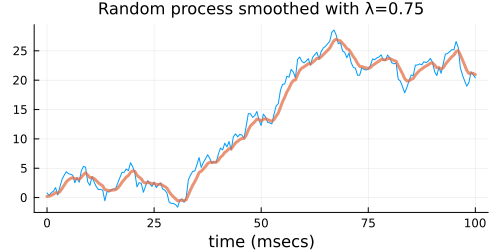

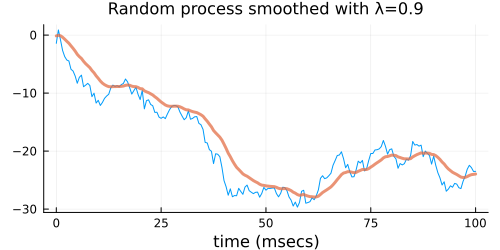

In [3]:
plotkw = (size=(500,250), legend=false, titlefontsize=11, xlabel="time (msecs)")
fs     = 2000
t      = 0 : 1/fs : 0.1

for lambda in [0.75, 0.9]
    x   = randprocess(length(t); sigma=1)
    y   = movingavg(x; lambda)
    fig = plot(10^3*t, [x y]; lw=[1 3], alpha=[1 0.75], plotkw...)
    title!("Random process smoothed with λ=$lambda")
    display(fig)
end


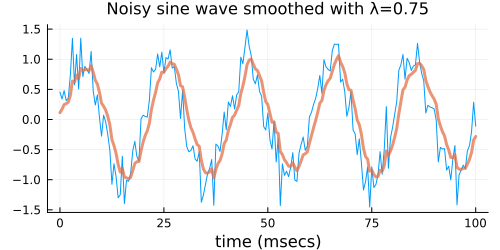

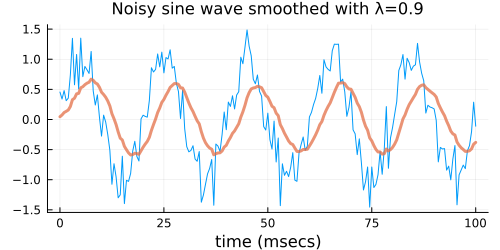

In [4]:
plotkw = (size=(500,250), legend=false, titlefontsize=11, xlabel="time (msecs)")
fs     = 2000
t      = 0 : 1/fs : 0.1

x = noisysignal.(t, t -> sinewave(t; f=50); tau=0.0, T=0.1, sigma=0.25)
y = movingavg(x; lambda=0.75)

for lambda in [0.75, 0.9]
    y    = movingavg(x; lambda)
    fig = plot(10^3*t, [x y]; lw=[1 3], alpha=[1 0.75], plotkw...)
    title!("Noisy sine wave smoothed with λ=$lambda")
    display(fig)
end


### 1c. System delay
The filtered waveform not being exactly superimposed on the noisy signal is primarily due to the inherent delay introduced by the moving average filter. This delay is a consequence of the filter's nature, which relies on past values to compute the current output. Specifically, for a simple moving average filter defined by a parameter $\lambda$, the output at any time is a weighted combination of the current input and the previous output. This creates a lag in the response of the filter to changes in the input signal.

### Response Lag and Its Implications

The delay or lag introduced by the filter means that the peak (or any feature) of the filtered signal will appear later than the same feature in the original signal. The magnitude of this lag depends on the value of $\lambda$; a higher $\lambda$ (closer to 1) will result in more smoothing but also a larger lag, as the output depends more heavily on past outputs. Conversely, a lower $\lambda$ reduces the lag but also decreases the smoothing effect.

### Adjusting for Delay

For some filters, like the simple moving average, it's possible to adjust for this delay to some extent by shifting the output signal. However, for the exponential moving average defined by the $\lambda$ parameter as discussed here, the lag is not constant over time but depends on the input signal's characteristics. Thus, perfectly centering the average might not be straightforward. Nevertheless, for illustrative purposes, one can approximate the delay and adjust the plot to better align the smoothed signal with the original noisy signal.


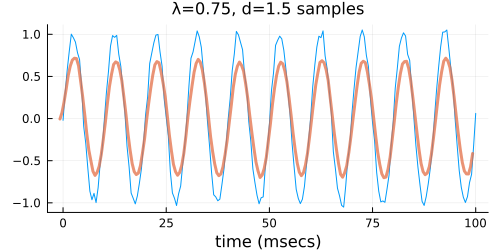

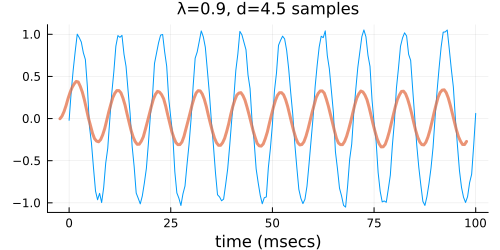

In [5]:
plotkw = (size=(500,250), legend=false, titlefontsize=11, xlabel="time (msecs)")
fs     = 2000
t      = 0 : 1/fs : 0.1

x = noisysignal.(t, t -> sinewave(t; f=100); tau=0.0, T=0.1, sigma=0.05)

for (lambda, d) in zip([0.75, 0.9], [1.5, 4.5])
    y = movingavg(x; lambda)

    # plot the signal
    fig = plot(10^3*t, x; lw=1, plotkw...)

    # convert delay (which is in samples) to seconds
    tau = d/fs

    # plot the delay-corrected filter output
    plot!(10^3*(t .- tau), y; lw=3, alpha=0.75, plotkw...)

    title!("λ=$lambda, d=$d samples")
    display(fig)
end

### 2. IIR Filters

### 2a. Implementation


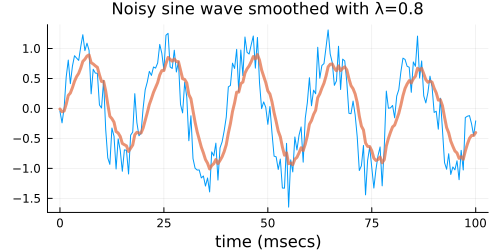

In [6]:
# First show the output using movingavg

plotkw = (size=(500,250), legend=false, titlefontsize=11, xlabel="time (msecs)")
fs     = 2000
t      = 0 : 1/fs : 0.1

x = noisysignal.(t, t -> sinewave(t; f=50); tau=0.0, T=0.1, sigma=0.25)

lambda = 0.8
yma = movingavg(x; lambda)

fig = plot(10^3*t, [x yma]; lw=[1 3], alpha=[1 0.75], plotkw...)
title!("Noisy sine wave smoothed with λ=$lambda")

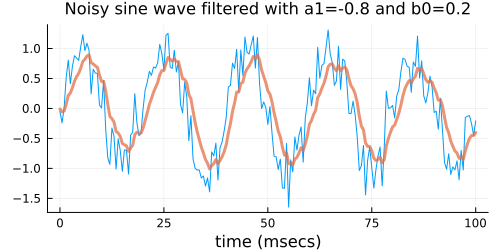

In [7]:
# Then contrast it with filterIIR

plotkw = (size=(500,250), legend=false, titlefontsize=11, xlabel="time (msecs)")
fs     = 2000
t      = 0 : 1/fs : 0.1

# Note a and b are vector arguments with one element each.
a = [-lambda]
b = [1-lambda]

yiir = filterIIR(x; a, b)

fig = plot(10^3*t, [x yiir]; lw=[1 3], alpha=[1 0.75], plotkw...)

# By convention indexing of a starts with one and b starts with zero.
# title!("Noisy sine wave filtered with a1=$(a[1]) and b0=$b[1]")

b0 = round(b[1], digits=1) # workaround floating point precision
title!("Noisy sine wave filtered with a1=$(a[1]) and b0=$b0")

In [8]:
# Your two methods should be mathematically identical.
sum(yiir .- yma)

0.0

### 2b. First order low- and high-pass IIR filters


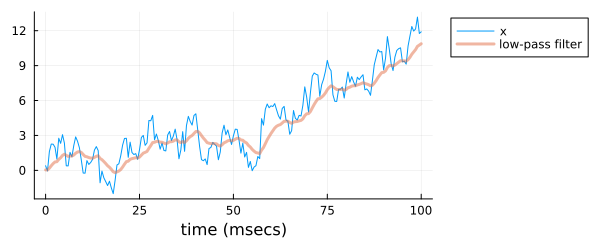

In [9]:
plotkw = (size=(600,250), legend=:outertopright, titlefontsize=11, xlabel="time (msecs)", bottom_margin=20Plots.px)
fs     = 2000
t      = 0 : 1/fs : 0.1

x = randprocess(length(t); sigma=1)
y = filterIIR(x; a=[-0.9], b=[0.1])

fig = plot(10^3*t, x; label="x", plotkw...)
plot!(10^3*t, y; lw=3, alpha=0.5, label="low-pass filter", plotkw...)



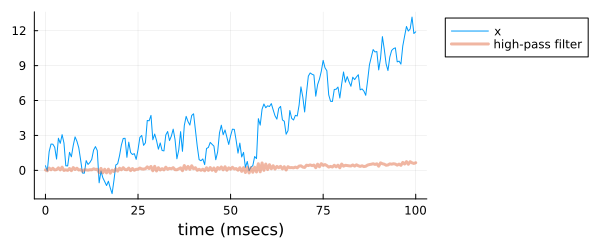

In [10]:
plotkw = (size=(600,250), legend=:outertopright, titlefontsize=11, xlabel="time (msecs)", bottom_margin=20Plots.px)
fs     = 2000
t      = 0 : 1/fs : 0.1

# use the same input signal x from the previous cell.
y = filterIIR(x; a=[0.9], b=[0.1])

fig = plot(10^3*t, x; label="x", plotkw...)
plot!(10^3*t, y; lw=3, alpha=0.5, label="high-pass filter", plotkw...)


#### Contrast the first order difference equations of these two filters.  How is each achieving the result?

The first order difference equations for these systems are:


**Low-pass Filter**

$\quad y[n] = 0.1x[n] + 0.9y[n-1]$

**High-pass Filter**

$\quad y[n] = 0.1x[n] - 0.9y[n-1]$

The low-pass filter is equivalent to computing a moving average, because a small fraction of the current input is combined with a larger fraction of the previous output, which as the effect of accumulating the values of the signal and computing an average.

The high-pass filter is in effect subtracting the smoothed input from the current input, and so removes slower variation.


### 2c. Second order bandpass filters

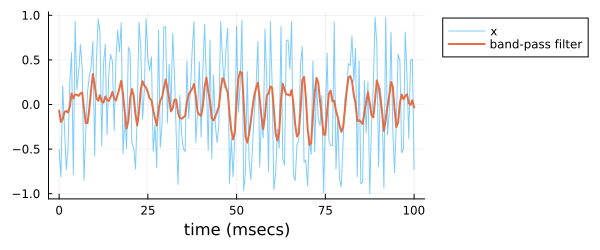

In [11]:
plotkw = (size=(600,250), legend=:outertopright, titlefontsize=11, xlabel="time (msecs)", bottom_margin=20Plots.px)
fs     = 2000
t      = 0 : 1/fs : 0.1

x = 2*rand(length(t)) .- 1

a = [-1.265, 0.81]
b = [0.135]

y = filterIIR(x; a, b)

fig = plot(10^3*t, x; alpha=0.5, label="x", plotkw...)
plot!(10^3*t, y; lw=2, label="band-pass filter", plotkw...)

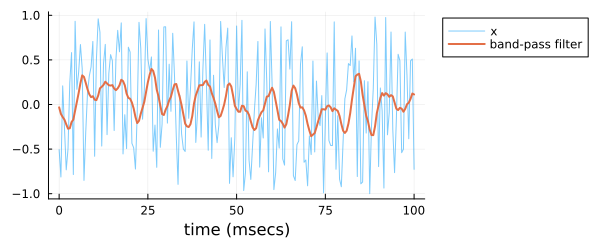

In [12]:
plotkw = (size=(600,250), legend=:outertopright, titlefontsize=11, xlabel="time (msecs)", bottom_margin=20Plots.px)
fs     = 2000
t      = 0 : 1/fs : 0.1

a = [-1.702, 0.81]
b = [0.063]

y = filterIIR(x; a, b)

fig = plot(10^3*t, x; alpha=0.5, label="x", plotkw...)
plot!(10^3*t, y; lw=2, label="band-pass filter", plotkw...)


#### What you should see is that these 2nd order filters filter out both the low and the high frequency components.  These are called **bandpass** filters.  Contrast the two IIR difference equations and provide an interpretation of how they are computing the result.

The filter equations are:

$\quad \text{y[n] = 0.135x[n] + 1.265y[n-1] - 0.81y[n-2]}\\$
$\quad \text{y[n] = 0.063x[n] + 1.702y[n-1] - 0.81y[n-2]}$

We can interpret these as a combination of a low-pass and a high pass filter. Both filters subtract the same fraction of $y[n-2]$, which has the effect of a high-pass filter, but in the second example, the signal is smoothed more and so passes lower frequencies.

In summary, the computation of the result by these filters involves a delicate balance between the feedback (resonance and selectivity) and feedforward (gain) components. The specific coefficients determine the exact nature of the bandpass filtering effect, including which frequencies are allowed to pass and how sharply frequencies outside this range are attenuated.


### 2d. Characterizing the filter response

We have seen how filtering can process the signal to smooth it or remove low-frequency variation.  Here we want to focus on this question: If we are given an unknown system, how would we characterize its response?  Is there a way to measure the input-output relationship in a systematic way?


To characterize the response of an unknown system and understand its input-output relationship in a systematic way, we utilize a technique known as **system identification**. This process typically involves the following key steps:

1. **Stimulus or Test Signal:** Apply a well-defined input signal (or stimulus) to the system. Common choices for the stimulus include impulse signals, step signals, and sine waves across a range of frequencies. For a broad characterization, a white noise signal or a sweep sine signal (which covers a range of frequencies) can be particularly effective because they can probe the system across its entire operational bandwidth.

2. **Measure the Output:** Record the system's output in response to the input stimulus. This output reflects how the system processes or modifies the input signal.

3. **Analyze the Response:** Use signal processing techniques to analyze the relationship between the input and output signals. Key methods include:
   - **Frequency Response Analysis:** If the input is a sine wave, varying its frequency can help determine the system's frequency response. The output can be analyzed to find the gain and phase shift introduced by the system at each frequency.
   - **Impulse Response Analysis:** If the input is an impulse signal, the output (the impulse response) directly characterizes the system's time-domain behavior. This can be transformed into the frequency domain using the Fourier Transform for further analysis.
   - **Step Response Analysis:** The system's response to a step input can reveal its transient and steady-state behaviors, including time constants and damping characteristics.
   - **Spectral Analysis:** For complex or broadband inputs like white noise, comparing the power spectral density (PSD) of the input and output signals can reveal the system's transfer function.

4. **Model the System:** Based on the analysis, develop a mathematical model that describes the input-output relationship. This model could be in the form of a transfer function in the frequency domain or a difference (discrete-time) or differential (continuous-time) equation in the time domain.

5. **Validation:** Validate the model by comparing its predicted output to the actual output of the system under various input conditions not used during the identification process.

This systematic approach allows engineers and scientists to understand and predict how a system will respond to future inputs, design appropriate controllers or filters, and optimize system performance. The choice of stimulus and specific analysis techniques can vary depending on the system's nature and the desired characteristics to be understood.

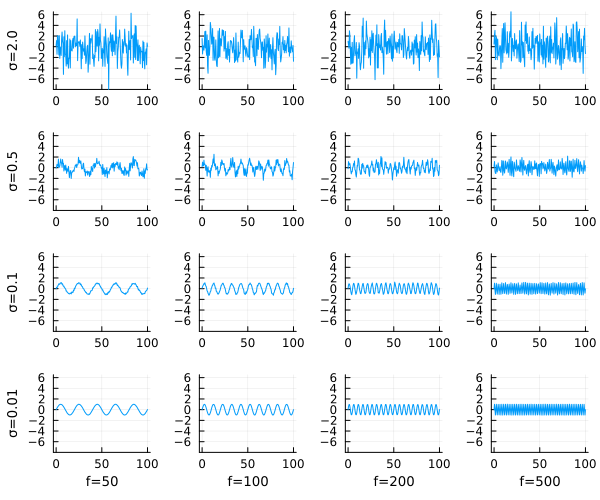

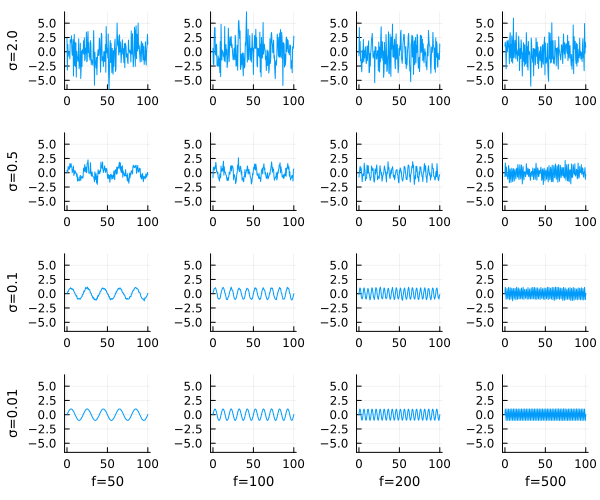

In [13]:
fs      = 2000
t       = 0 : 1/fs : 0.1
freqs   = [50, 100, 200, 500]
sigma_s = [2.0, 0.5, 0.1, 0.01]

# first set of filter coeffs from 2c
a = [-1.265, 0.81]
b = [0.135]

fig = noisefreqplot(; t, freqs, sigma_s, a, b)
display(fig)

# second set of filter coefs from 2c
a = [-1.702, 0.81]
b = [0.063]

fig = noisefreqplot(; t, freqs, sigma_s, a, b)
display(fig)


#### What can you observe about the relation between the output an input?

If the input is a sinusoid, the output is a scaled version of it.

1. **Frequency Dependence:** Only sine waves with frequencies within the filter's passband are clearly visible; other frequencies are attenuated.

2. **Noise Reduction:** The level of noise is generally reduced, more so for noise at frequencies outside the filter's passband.

3. **Signal Clarity:** Signals within the passband become clearer as noise is reduced, while signals outside the passband may become less distinguishable.

Peak frequency: 250.12506253126566 Hz with power 0.49520917729761943


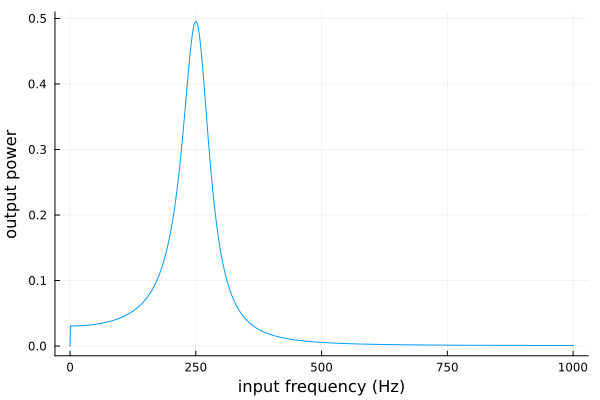

Peak frequency: 100.05002501250625 Hz with power 0.5159516731664644


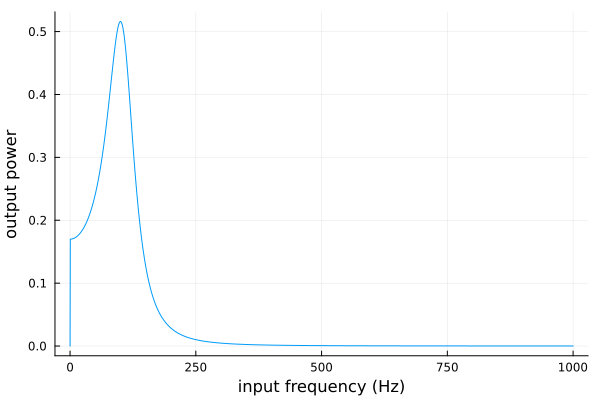

In [14]:
# First set of filter coefficients
filterA = [-1.265, 0.81]
filterB = [0.135]
display(plotFrequencyResponse(filterA, filterB))

# Second set of filter coefficients
filterA = [-1.702, 0.81]
filterB = [0.063]
display(plotFrequencyResponse(filterA, filterB))


#### How would you characterize the system response?

The first set of coefficients yields a bandpass filter with a peak frequency of 250 Hz.$\\$
The second gives a bandpass filter with a peak of 100 Hz.

1. **Passband:** The frequency range where the system allows signals to pass with minimal attenuation.
2. **Cut-off Frequencies:** Points where the system starts significantly attenuating the signal.
3. **Stopband:** Frequencies where the system heavily reduces signal power.
4. **Bandwidth:** The width of the passband, typically defined between points where power drops to half its peak.
5. **Resonances:** Peaks in response outside the passband, indicating resonant frequencies.

### 3. The impulse response function

### 3a. Deriving the impulse response function

The formula for the system response,

$$
y[n] = \sum_{k=-\infty}^{\infty} x[k] h[n-k],
$$

relies on the principles of linearity and time invariance for linear time-invariant (LTI) systems. Here's how these principles are essential:

1. **Linearity**: This principle is embodied in the superposition property, which states that the response to a linear combination of inputs, $\alpha x_1[n] + \beta x_2[n]$, is the same linear combination of the responses, $\alpha y_1[n] + \beta y_2[n]$. For an arbitrary signal $x[n]$ represented as a sum of scaled and shifted impulses, the system's response is the corresponding sum of the responses to these impulses, maintaining the scaling and shifting. Mathematically, if

$$
x[n] = \sum_k \alpha_k x_k[n]
$$

and the responses to individual inputs $x_k[n]$ are

$$
y_k[n] = \mathcal{H}(x_k[n]),
$$

then the output for the superposition of inputs is

$$
y[n] = \sum_k \alpha_k y_k[n].
$$

2. **Time-invariance**: This property ensures that shifting the input signal $x[n]$ in time results in an equivalent shift in the output $y[n]$. If the system's response to an impulse $\delta[n]$ is $h[n]$, then the response to a delayed impulse $\delta[n-k]$ is $h[n-k]$. Without time invariance, the response to a shifted impulse would not be a straightforward shifted version of $h[n]$.

The impulse response $h[n]$ is defined as the system's response to a unit impulse at time zero. Knowing $h[n]$, the output for any arbitrary input $x[n]$ can be predicted by convolving the input with the impulse response. This relationship is central to LTI system analysis and design, highlighting the importance of linearity and time invariance.

### 3b. Impulse responses

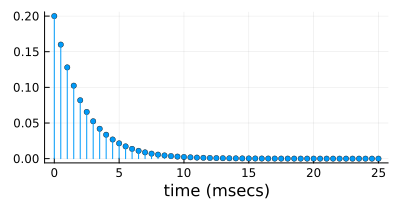

In [15]:
# moving average (low pass)

plotkw = (size=(400,200), legend=false, titlefontsize=11,
    line=:stem, marker=:circle, markersize=3, xlabel="time (msecs)")

fs     = 2000
t      = 0 : 1/fs : 0.025
x      = zeros(length(t))
x[1]   = 1.0
lambda = 0.8
y      = filterIIR(x; a=[-lambda], b=[1-lambda])

plot(10^3*t, y; label="h[n]", plotkw...)

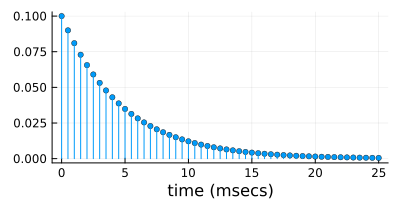

In [16]:
# low pass

plotkw = (size=(400,200), legend=false, titlefontsize=11,
    line=:stem, marker=:circle, markersize=3, xlabel="time (msecs)")

fs     = 2000
t      = 0 : 1/fs : 0.025
x      = zeros(length(t))
x[1]   = 1.0

y = filterIIR(x; a=[-0.9], b=[0.1])
plot(10^3*t, y; label="h[n]", plotkw...)

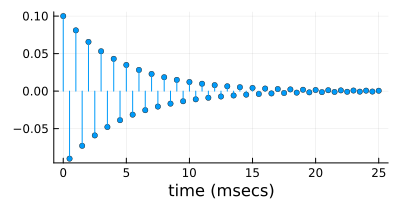

In [17]:
# high pass

plotkw = (size=(400,200), legend=false, titlefontsize=11,
    line=:stem, marker=:circle, markersize=3, xlabel="time (msecs)")

fs     = 2000
t      = 0 : 1/fs : 0.025
x      = zeros(length(t))
x[1]   = 1.0

y = filterIIR(x; a=[0.9], b=[0.1])
plot(10^3*t, y; label="h[n]", plotkw...)

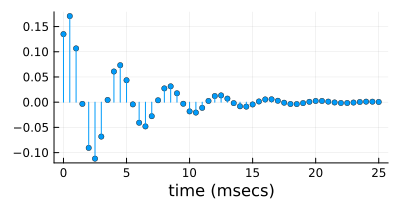

In [18]:
# bandpass 1

plotkw = (size=(400,200), legend=false, titlefontsize=11,
    line=:stem, marker=:circle, markersize=3, xlabel="time (msecs)")

fs     = 2000
t      = 0 : 1/fs : 0.025
x      = zeros(length(t))
x[1]   = 1.0

y = filterIIR(x; a=[-1.265, 0.81], b=[0.135])
plot(10^3*t, y; label="h[n]", plotkw...)

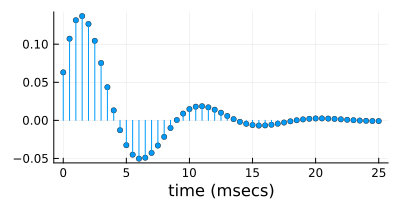

In [19]:
# bandpass 2

plotkw = (size=(400,200), legend=false, titlefontsize=11,
    line=:stem, marker=:circle, markersize=3, xlabel="time (msecs)")

fs     = 2000
t      = 0 : 1/fs : 0.025
x      = zeros(length(t))
x[1]   = 1.0

y = filterIIR(x; a=[-1.702, 0.81], b=[0.063])
plot(10^3*t, y; label="h[n]", plotkw...)

#### How can you interpret the impulse response functions in terms of a weighted average to explain the system response?

At each sample, the output sample is a linear combination of the previous samples. We can see that the moving average and low pass filters effectively take a diminishing weighted average of the previous 10 - 15 ms of samples. The high pass filter alternates positive and negative values, so slower waveforms will tend to cancel, but high frequencies that align with the alternation will be preserved. The band pass filters have a similar behavior except at the frequency range that is passed.


### 4. Filtering with convolution

### 4a. Implementing convolution 

In [20]:
plotkw = (size=(500, 250), legend=false, titlefontsize=11)
fs     = 2000
t      = 0 : 1/fs : 0.100
x      = rand(length(t));
a      = [-1.265, 0.81]
b      = [0.135]
h      = filterIIR(x; a, b)
x      = 2*rand(length(t)) .- 1
sx     = x

yiir   = filterIIR(x; a, b)


201-element Vector{Float64}:
 -0.10298891372395085
 -0.259556936406259
 -0.24160468344792996
 -0.04195931977482392
  0.14070232835934326
  0.20382512692203442
  0.0731192026002973
 -0.05776248571510878
 -0.13083397167585686
 -0.1133515507707551
 -0.01853788201219775
  0.18457845037206855
  0.19110156027938027
  ⋮
 -0.1114280135111444
  0.20102198896626888
  0.3249158505470223
  0.3643434617045946
  0.18572943291091049
 -0.09608315987015267
 -0.15301513537104713
 -0.07113061418524852
 -0.06826420413403202
 -0.10324675656137594
 -0.21013545574306575
 -0.1523171526666297

In [21]:
length_of_response = length(yiir)
impulse = zeros(length_of_response)
impulse[1] = 1

h = filterIIR(impulse; a, b)

yh = convolve(x; h)

201-element Vector{Float64}:
 -0.10298891372395085
 -0.259556936406259
 -0.24160468344792993
 -0.04195931977482392
  0.14070232835934326
  0.20382512692203447
  0.07311920260029733
 -0.057762485715108766
 -0.1308339716758569
 -0.11335155077075516
 -0.018537882012197825
  0.18457845037206846
  0.19110156027938024
  ⋮
 -0.1114280135111443
  0.20102198896626908
  0.3249158505470222
  0.3643434617045949
  0.18572943291091035
 -0.09608315987015278
 -0.15301513537104725
 -0.0711306141852485
 -0.06826420413403203
 -0.103246756561376
 -0.21013545574306577
 -0.15231715266662965

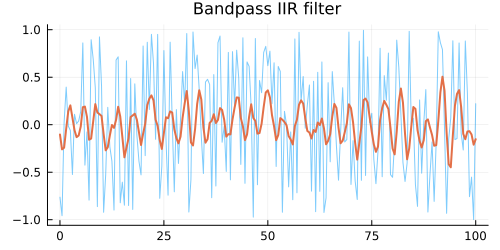

In [22]:
fig1 = plot(10^3*t, x; alpha=0.5, plotkw...)
plot!(10^3*t, yiir; lw=2, title="Bandpass IIR filter", plotkw...)

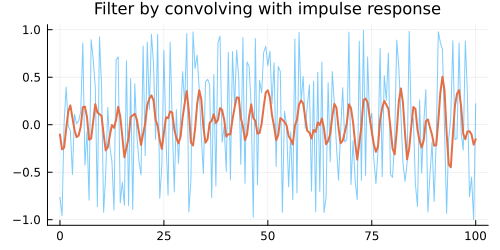

In [23]:
fig2 = plot(10^3*t, x; alpha=0.5, plotkw...)
plot!(10^3*t, yh; lw=2, title="Filter by convolving with impulse response", 
    plotkw...)


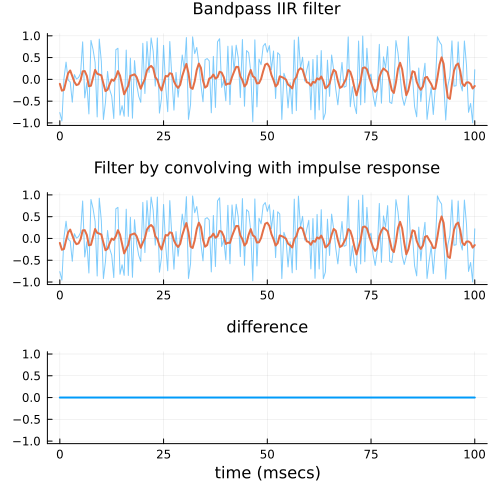

In [24]:
ylim = ylims(fig2)

fig3 = plot(10^3*t, yh - yiir; lw=2, ylim, 
    title="difference", xlabel="time (msecs)", plotkw...);

plot(fig1, fig2, fig3; layout=(3,1), legend=false, size=(500,500))


In [25]:
sum(yh - yiir)

1.2472661792273243e-15

### 4b. FIR filtering

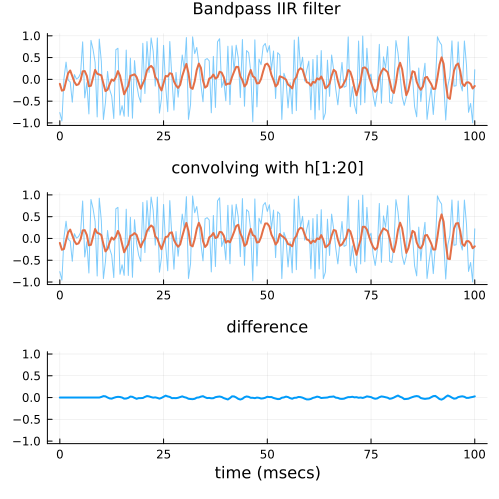

In [26]:
tlim = 0.01
K    = findlast(t .< tlim)
hfir = h[1:K]
yfir = convolve(x; h=hfir)

fig2 = plot(10^3*t, x; alpha=0.5, plotkw...)
plot!(10^3*t, yfir; lw=2, title="convolving with h[1:$K]")

fig3 = plot(10^3*t, yh - yfir; lw=2, ylim, xlabel="time (msecs)",
title="difference", plotkw...)

fig = plot(fig1, fig2, fig3; layout=(3,1), legend=false, size=(500,500))
display(fig)

In [27]:
sum(yfir - yiir)

0.15718489975109157

### 4c. Using matched filters to detect signals in noise

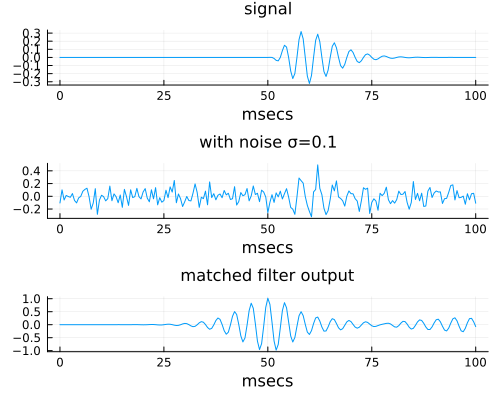

In [28]:
sigma = 0.1

fig = matched_filter_fig(; sigma)

#### Comment on the effectiveness of this approach vs threshold detection.
The effectiveness of using a matched filter approach versus simple threshold detection for signal detection in noise can be summarized as follows:

### Matched Filter Approach:

1. **Signal-to-Noise Ratio (SNR) Enhancement**: Matched filtering is designed to maximize the SNR, making it particularly effective in situations where the signal is deeply buried in noise. By correlating the received signal with a template of the expected signal, matched filtering accumulates the signal energy while dispersing noise energy, thereby enhancing the detectability of the signal.

2. **Optimal for Known Signals**: When the shape and structure of the signal are known a priori, matched filtering is theoretically the optimal linear filter for detecting the presence of the signal within noisy environments.

3. **Complexity and Computational Cost**: Implementing matched filtering, especially in real-time applications, can be computationally intensive as it involves convolution operations, which might be costly for long signals or in high-dimensional data.

4. **Sensitivity to Signal Variations**: While extremely effective for detecting signals that match the template, its performance can degrade if the actual signal deviates from the expected shape due to changes in frequency, phase, or other characteristics.

### Threshold Detection:

1. **Simplicity and Ease of Implementation**: Threshold detection is much simpler to implement and understand. It involves setting a level (threshold) and detecting when the signal exceeds this level.

2. **Less Effective in Noisy Environments**: Unlike matched filtering, threshold detection does not inherently improve the SNR. Therefore, it is less effective in noisy environments, especially where noise levels are close to or exceed the signal levels.

3. **Quick and Low-Cost**: It is suitable for real-time applications and systems with limited computational resources. 

4. **Robustness to Signal Variations**: Threshold methods can be more robust to variations in the signal's shape or form, as they do not rely on the signal matching a specific template. However, they are more susceptible to false alarms due to noise spikes.

### Conclusion:

The choice between matched filtering and threshold detection depends on the specific application and environment:

- **Matched Filtering** is preferred when the exact form of the signal is known and when operating in highly noisy environments, as it provides superior detection capabilities by enhancing the SNR.

- **Threshold Detection** is more suited for applications where computational simplicity, speed, and robustness to unknown signal variations are more critical than optimal detection in noisy conditions.

In practice, the choice can also be influenced by the acceptable rates of false positives (false alarms) and false negatives (missed detections), as well as by the dynamic range of the signals and noise within the system.

In [29]:
# Quiz Question 1

# Multiple choice question.

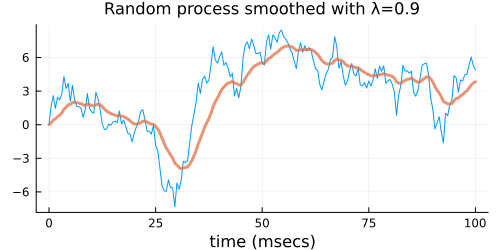

In [30]:
# Quiz Question 2

plotkw = (size=(500,250), legend=false, titlefontsize=11, xlabel="time (msecs)")
fs     = 2000
t      = 0:1/fs:0.1
sigma  = 1

for lambda in [0.9]
    x = randprocess(length(t); sigma=sigma)
    y = movingavg(x; lambda)
    fig = plot(10^3*t, [x y]; lw=[1 3], alpha=[1 0.75], plotkw...)
    title!("Random process smoothed with λ=$lambda")
    display(fig)
end

In [31]:
# Quiz Question 3

# Given lambda value
lambda = 0.75

# Calculate M from lambda
M = 1 / (1 - lambda)

# Approximate the effective delay
effective_delay = (M - 1) / 2

println("Calculated M: ", M)
println("Approximate effective delay (in samples): ", effective_delay)


Calculated M: 4.0
Approximate effective delay (in samples): 1.5


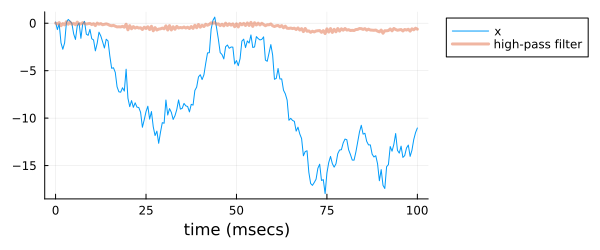

In [32]:
# Quiz Question 4

plotkw = (size=(600,250), legend=:outertopright, 
    titlefontsize=11, xlabel="time (msecs)", 
    bottom_margin=20Plots.px) # prevent x label from being cutoff

fs = 2000
t  = 0 : 1/fs : 0.1
x  = randprocess(length(t); sigma=1)
y  = filterIIR(x; a=[0.9], b=[0.1])

fig = plot(10^3*t, x; label="x", plotkw...)
plot!(10^3*t, y; lw=3, alpha=0.5, label="high-pass filter", plotkw...)

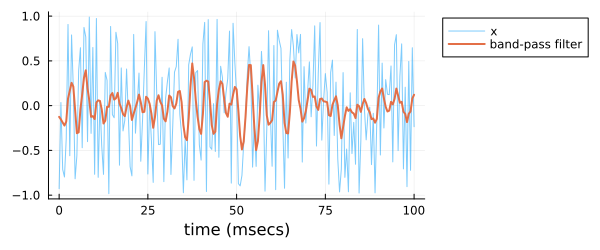

In [33]:
# Quiz Question 5

fs = 2000
t = 0 : 1/fs : 0.1

x = 2*rand(length(t)) .- 1

a = [-1.265, 0.81]
b = [0.135]

y = filterIIR(x; a, b)

fig = plot(10^3*t, x; alpha=0.5, label="x", plotkw...)
plot!(10^3*t, y; lw=2, label="band-pass filter", plotkw...)

display(fig)

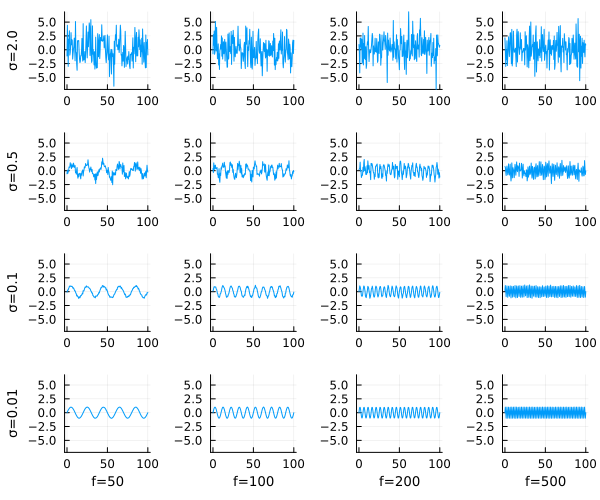

In [34]:
# Quiz Question 6

fs      = 2000
t       = 0 : 1/fs : 0.1
freqs   = [50, 100, 200, 500]
sigma_s = [2.0, 0.5, 0.1, 0.01]
a       = [-1.265, 0.81]
b       = [0.135]

fig = noisefreqplot(; t, freqs, sigma_s, a, b)
display(fig)

Peak frequency: 250.12506253126566 Hz with power 0.49520917729761943


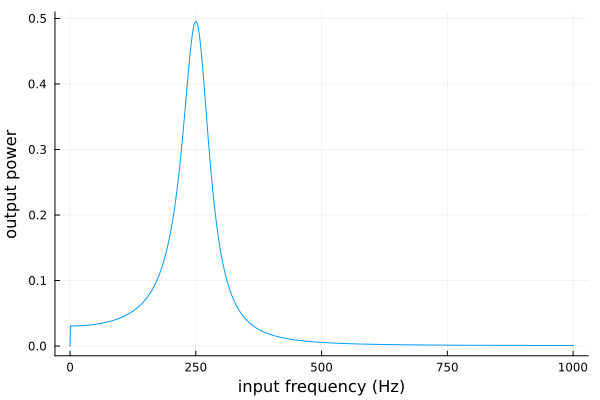

In [35]:
# Quiz Question 7
filterA = [-1.265, 0.81]
filterB = [0.135]
display(plotFrequencyResponse(filterA, filterB))

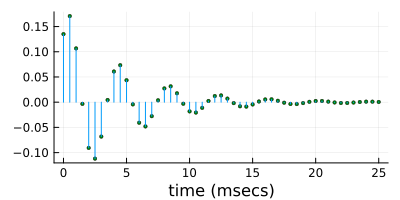

In [36]:
# Quiz Question 8

plotkw = (size=(400,200), legend=false, titlefontsize=11,
    line=:stem, marker=:circle, markercolor=:green, markersize=2, xlabel="time (msecs)")

fs     = 2000
t      = 0 : 1/fs : 0.025
x      = zeros(length(t))
x[1]   = 1.0

y = filterIIR(x; a=[-1.265, 0.81], b=[0.135])
plot(10^3*t, y; label="h[n]", plotkw...)


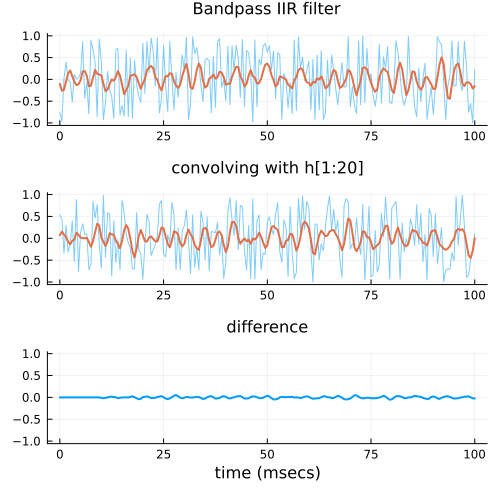

In [37]:
# Quiz Question 9

plotkw = (size=(500, 250), legend=false, titlefontsize=11)
fs     = 2000
t      = 0 : 1/fs : 0.100
x      = rand(length(t));
a      = [-1.265, 0.81]
b      = [0.135]
h      = filterIIR(x; a, b)
x      = 2*rand(length(t)) .- 1
sx     = x

yiir   = filterIIR(x; a, b)

length_of_response = length(yiir)
impulse = zeros(length_of_response)
impulse[1] = 1

h    = filterIIR(impulse; a, b)
yh   = convolve(x; h)

tlim = 0.01
K    = findlast(t .< tlim)
hfir = h[1:K]
yfir = convolve(x; h=hfir)

fig2 = plot(10^3*t, x; alpha=0.5, plotkw...)
plot!(10^3*t, yfir; lw=2, title="convolving with h[1:$K]")

ylim = ylims(fig2)

fig3 = plot(10^3*t, yh - yfir; lw=2, ylim, xlabel="time (msecs)",
title="difference", plotkw...)

fig = plot(fig1, fig2, fig3; layout=(3,1), legend=false, size=(500,500))
display(fig)



centeridx = argmax(hg) = 85


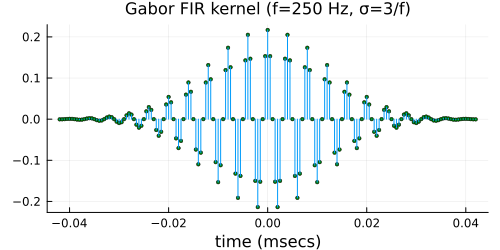

In [38]:
# Quiz Question 10

plotkw = (size=(500,250), legend=false, titlefontsize=11,
    line=:stem, marker=:circle, markercolor=:green, markersize=2, xlabel="time (msecs)")

fs    = 2000
f     = 250
sigma = 3/f
gt    = -3.5sigma : 1/fs : 3.5sigma
hg    = gabore(gt; f, sigma)

@show centeridx = argmax(hg)

fig = plot(gt, hg,; title="Gabor FIR kernel (f=$f Hz, σ=3/f)", plotkw...)
display(fig)

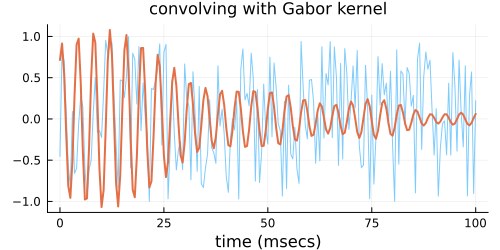

In [39]:
# Quiz Question 11

plotkw = (size=(500, 250), legend=false, titlefontsize=11)
fs     = 2000
t      = 0 : 1/fs : 0.100
x      = 2*rand(length(t)) .- 1
ygabor = convolve(x; h=hg, h0=centeridx)

fig = plot(10^3*t, x; alpha=0.5, xlabel="time (msecs)", plotkw...)
plot!(10^3*t, ygabor; lw=2, title="convolving with Gabor kernel", plotkw...)
display(fig)

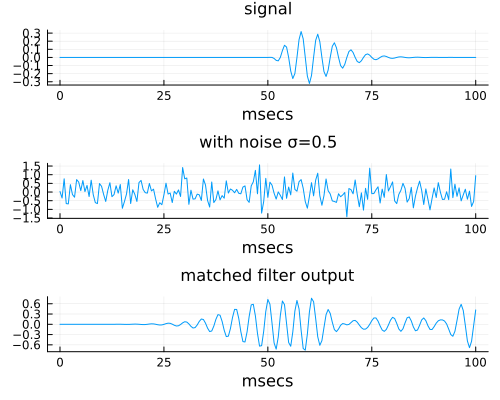

In [40]:
# Quiz Question 12
sigma = 0.5

fig = matched_filter_fig(; sigma)